In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");


# Importing the necessary libraries in addition to provided libraries
import jax
import numpy as np
import jax.numpy as jnp
from diffrax import diffeqsolve, Tsit5, ODETerm, SaveAt
from jax import jacobian, jit
from jax import jit, vmap


# Homework 2

## References

+ Module 3: Uncertainty Propagation Through Scientific Models
   - Local sensitivity analysis
   - Global sensitivity analysis

## Instructions

+ Type your name and email in the "Student details" section below.
+ Develop the code and generate the figures you need to solve the problems using this notebook.
+ For the answers that require a mathematical proof or derivation you should type them using latex. If you have never written latex before and you find it exceedingly difficult, we will likely accept handwritten solutions.
+ The total homework points are 100. Please note that the problems are not weighed equally.

## Student details

+ **First Name: Shaunak**
+ **Last Name: Mukherjee**
+ **Email: mukher86@purdue.edu**
+ **Used generative AI to complete this assignment (Yes/No): No**
+ **Which generative AI tool did you use (if applicable)?: NA**

## Problem 1 - Local sensitivity analysis of nonlinear dynamical system

Consider the Duffing oscillator:

$$\ddot{x} + \delta \dot{x} + \alpha x + \beta x^3 = \gamma \cos(\omega t)$$

where $\delta$, $\alpha$, $\beta$, $\gamma$, and $\omega$ are constants. As a system of first order equations, introducing $v = \dot{x}$, we have:

$$\begin{align}
\dot{x} & = v \\
\dot{v} & = \gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{align}$$

The initial conditions are $x(0) = x_0$ and $v(0) = v_0$.
Denote by $\theta$ the **vector of all parameters and initial conditions**, i.e. $\theta = (x_0, v_0, \alpha, \beta, \gamma, \delta, \omega)$.
The vector field $f(x,v,t;\theta)$ is then given by:

$$f(x,v,t;\theta) = \begin{pmatrix}
v \\
\gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3
\end{pmatrix}.$$

### Part A: Implement the Duffing oscillator
Modify the code of [this example](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/up/sensitivity_analysis/03_example_ode.html) to create a solver that takes $\theta$ as an input and returns the solution of the Duffing oscillator for a given the interval of time $[0, 50]$ with a time step of 0.1.
Make sure your code can be vectorized with respect to $\theta$ and that it can be `jit`ed.

**Answer:**

In [2]:
# Your code and evidence that it works here

def vector_field_duff_oscil(t, y, theta):

    x = y[0]
    v = y[1]
    x0, v0, alpha, beta, gamma, delta, omega = theta[:7]
    return jnp.array(
        [
            v,
            gamma * jnp.cos(omega * t) - delta * v - alpha * x - beta * x ** 3
        ]
        
    )
@jax.jit #JIT solver
def solver_duff_oscil(theta):
    ts = jnp.linspace(0, 50, 2000)
    solver = Tsit5() 
    save_at = SaveAt(ts=ts)
    term = ODETerm(vector_field_duff_oscil)
    y0 = jnp.array([theta[0], theta[1]])

    solution = diffeqsolve(
        term,
        solver,
        t0= 0,                       # Initial time
        t1= 50,                      # Terminal time
        dt0= 0.1,                    # Initial timestep
        y0= y0,                      # Initial values
        args= theta,
        saveat= save_at
    )

    return solution.ys

### Part B: Plot the strange attractor

Fix the values of the parameters to: $\alpha = 1$, $\beta = 5, \gamma = 8, \delta = 0.02$, and $\omega = 0.5$. Use the solver you implemented in Part A to plot the [strange attractor](https://en.wikipedia.org/wiki/Attractor#Strange_attractor) of the Duffing oscillator. To do this, just sample the initial conditions $x_0$ and $v_0$ from a uniform distribution in the interval $[-1, 1]$ and do the scatter plot of the points $(x(t), v(t))$ at $t = 50$. It looks like [this](https://en.wikipedia.org/wiki/Duffing_equation#/media/File:Forced_Duffing_equation_Poincaré_section.png).

Hint: Just make a 2D array of $\theta$'s with the first two columns randomly sampled and the rest fixed. Then pass the samples through your vectorized and `jit`ed solver and plot the results.

**Answer:**

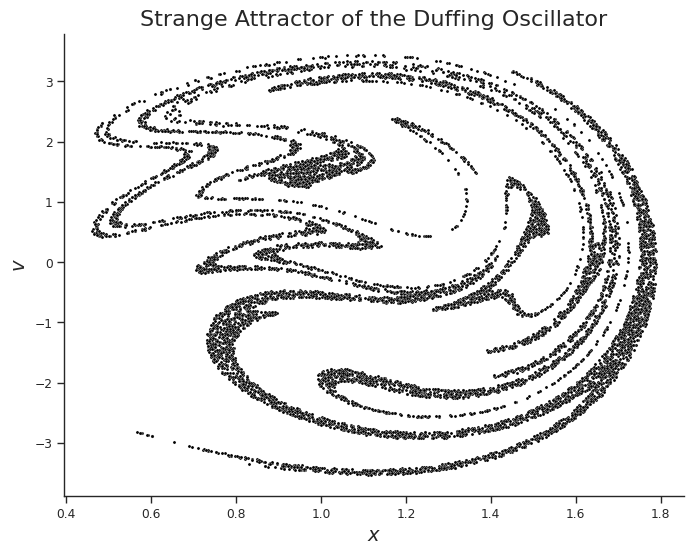

In [3]:
# Your response in code and markdown cells here

# Fixed parameters
alpha = 1.0
beta = 5.0
gamma = 8.0
delta = 0.02
omega = 0.5

num_samples = 10_000

# Generate random initial conditions
key = jax.random.PRNGKey(0)  
x0_samples = jax.random.uniform(key, (num_samples,), minval=-1.0, maxval=1.0)

key, subkey = jax.random.split(key) 
v0_samples = jax.random.uniform(subkey, (num_samples,), minval=-1.0, maxval=1.0)


# Create theta array with random initial conditions and fixed parameters
theta_samples = jnp.column_stack([
    x0_samples, 
    v0_samples, 
    jnp.full(num_samples, alpha),
    jnp.full(num_samples, beta),
    jnp.full(num_samples, gamma),
    jnp.full(num_samples, delta),
    jnp.full(num_samples, omega)
])

# Solve the Duffing oscillator
jit_solve_duffing = jax.vmap(solver_duff_oscil)
jit_sol_samples = jit_solve_duffing(theta_samples)

# Extract x and v at t=50   
final_states = jit_sol_samples[:, -1, :]
x_at_50, v_at_50 = final_states[:, 0], final_states[:, 1]

# Scatter plot for the strange attractor
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_at_50, y=v_at_50, s=5, color="black", alpha=1.0)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$v$", fontsize=14)
plt.title("Strange Attractor of the Duffing Oscillator", fontsize=16)
sns.despine()
plt.show()


### Part C: Local sensitivity analysis

Suppose you have a 1\% uncertainty about $\alpha, \beta, \delta, \gamma, \omega$ and 5\% uncertainty about the initial conditions $x_0$ and $v_0$. You can model this uncertainty with the Gaussian random variable:

$$
\theta \sim \mathcal{N}\left(
\begin{pmatrix}
0.5\\
0.5\\
1 \\
5 \\
0.37 \\
0.1 \\
1
\end{pmatrix},
\begin{pmatrix}
0.025^2 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0.025^2 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0.01^2 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0.05^2 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0.0037^2 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0.001^2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0.01^2
\end{pmatrix}
\right)
$$

+ Use local sensitivity analysis to propagate this uncertainty through the Duffing oscillator.
+ Use your results to plot 95\% credible intervals of $x(t)$ and $v(t)$ as functions of time for $t \in [0, 10]$.
+ Plot the estimated mean and variance of $x(t)$ and $v(t)$ as functions of time for $t \in [0, 30]$ and compare to Monte Carlo estimates using $10^5$ samples. For how long does the local sensitivity analysis give a good approximation of the mean and variance?

**Answer:**

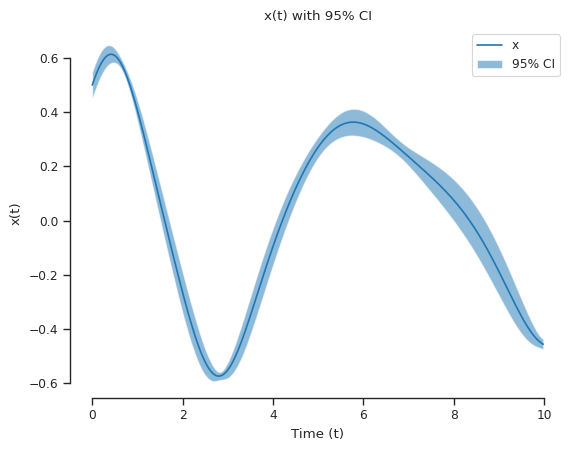

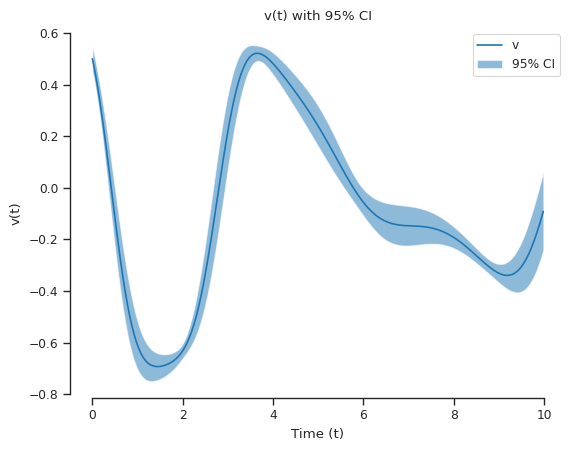

In [4]:
# Your response in code and markdown cells here

mean_theta = jnp.array([0.5, 0.5, 1.0, 5.0, 0.37, 0.1, 1.0]) 
cov_theta = jnp.diag(jnp.array([0.025**2, 0.025**2, 0.01**2, 0.05**2, 0.0037**2, 0.001**2, 0.01**2]))

# Solve the Duffing oscillator and calculate covariance
sol_mu = solver_duff_oscil(mean_theta)

# Calculate the Jacobian
jit_jac_solve_duffing = jax.jit(jacobian(solver_duff_oscil))
jac_sol_mu = jit_jac_solve_duffing(mean_theta)
sol_cov = np.einsum("kil,lm,rjm->rkij", jac_sol_mu, cov_theta, jac_sol_mu)

# Extract mean and standard deviations for plotting
x_mean = sol_mu[:, 0]
v_mean = sol_mu[:, 1]
x_std = np.sqrt(np.einsum("kkii->ki", sol_cov)[:, 0])
v_std = np.sqrt(np.einsum("kkii->ki", sol_cov)[:, 1])
x_var = x_std ** 2
v_var = v_std ** 2


# Filter time series data
t_max = 10
ts = jnp.linspace(0, 50, 2000)
idx = jnp.searchsorted(ts, t_max)
ts_filtered = ts[:idx]
mean_filtered_x = sol_mu[:idx, 0]
std_filtered_x = x_std[:idx]
mean_filtered_v = sol_mu[:idx, 1]
std_filtered_v = v_std[:idx]

# Plot function with credible intervals
def plot_with_ci(ts_filtered, mean_filtered, std_filtered, ylabel, label):
    fig, ax = plt.subplots()
    ax.plot(ts_filtered, mean_filtered, label=label)
    ax.fill_between(
        ts_filtered,
        mean_filtered - 1.96 * std_filtered,
        mean_filtered + 1.96 * std_filtered,
        alpha=0.5,
        label="95% CI",)
    ax.set(xlabel="Time (t)", ylabel=ylabel, title=f"{ylabel} with 95% CI")
    sns.despine(trim=True)
    plt.legend()
    plt.show()

# Plot x(t) and v(t) with credible intervals
plot_with_ci(ts_filtered, mean_filtered_x, std_filtered_x, ylabel="x(t)", label="x")
plot_with_ci(ts_filtered, mean_filtered_v, std_filtered_v, ylabel="v(t)", label="v")


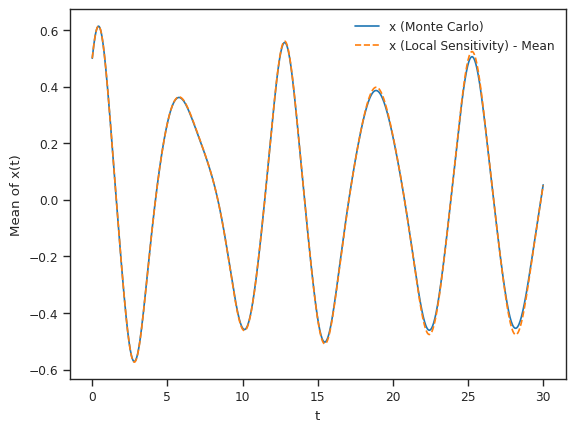

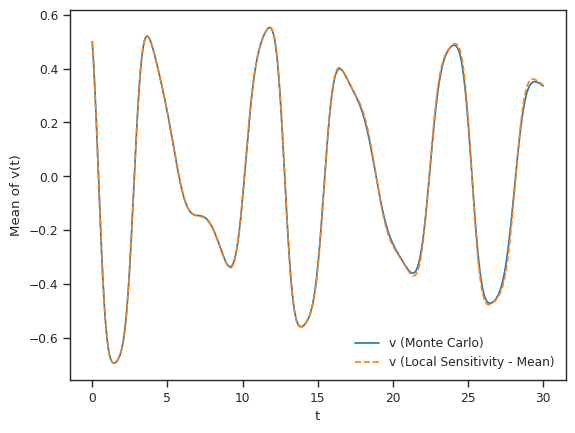

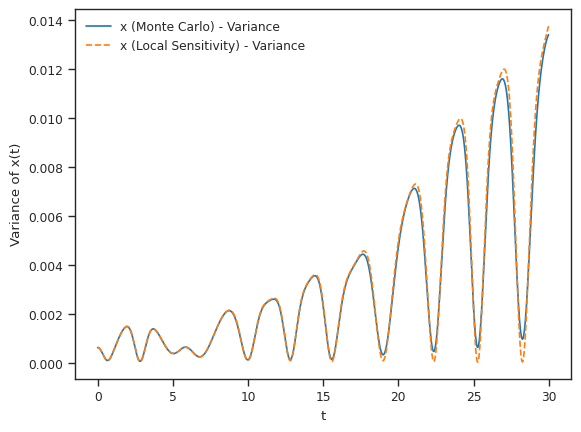

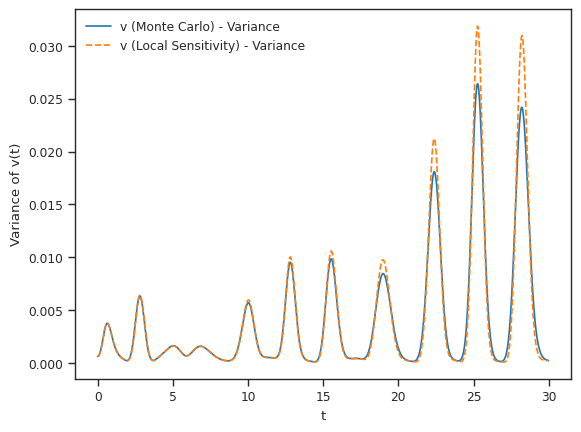

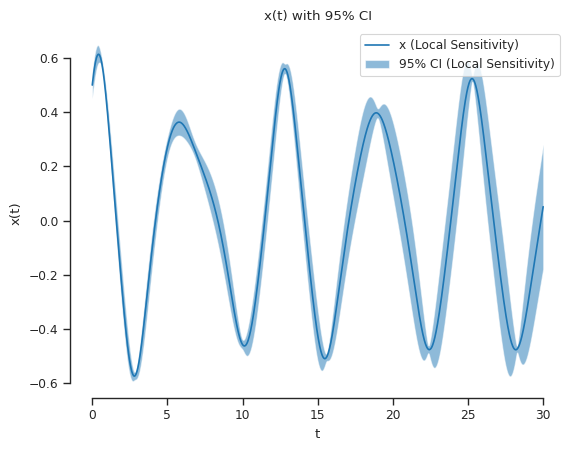

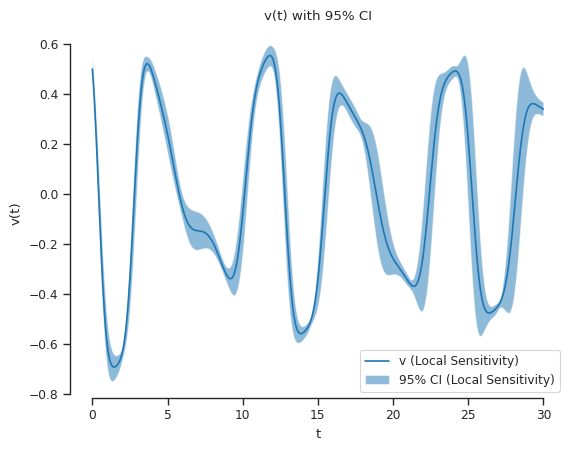

In [5]:
# Perform Monte Carlo simulation
num_samples = 100000
L = np.linalg.cholesky(cov_theta)
thetas = np.random.randn(num_samples, 7) @ L + mean_theta 
many_solve_duffing = jit(vmap(solver_duff_oscil, in_axes=(0,)))
sols_MC = many_solve_duffing(thetas)
mean_sol_MC = np.mean(sols_MC, axis=0)
std_sol_MC = np.std(sols_MC, axis=0)
var_sol_MC = np.var(sols_MC, axis=0)


# Adjust the time range to [0, 30]
t_max = 30
ts = jnp.linspace(0, 50, 2000)
idx = np.searchsorted(ts, t_max)
ts_filtered = ts[:idx]

# Estimated Mean Sensitivity and Monte Carlo results for x(t) and v(t)
# For x
fig, ax = plt.subplots()
ax.plot(ts_filtered, mean_sol_MC[:idx, 0], label="x (Monte Carlo)")
ax.plot(ts_filtered, sol_mu[:idx, 0], '--', label="x (Local Sensitivity) - Mean")
ax.set(xlabel="t", ylabel="Mean of x(t)")
ax.legend(frameon=False)

# For v
fig, ax = plt.subplots()
ax.plot(ts_filtered, mean_sol_MC[:idx, 1], label="v (Monte Carlo)")
ax.plot(ts_filtered, sol_mu[:idx, 1], '--', label="v (Local Sensitivity - Mean)")
ax.set(xlabel="t", ylabel="Mean of v(t)")
ax.legend(frameon=False)

# Estimated variance Sensitivity and Monte Carlo results for x(t) and v(t)
# For x
fig, ax = plt.subplots()
ax.plot(ts_filtered, var_sol_MC[:idx, 0], label="x (Monte Carlo) - Variance")
ax.plot(ts_filtered, x_var[:idx], '--', label="x (Local Sensitivity) - Variance")
ax.set(xlabel="t", ylabel="Variance of x(t)")
ax.legend(frameon=False)
# For v
fig, ax = plt.subplots()
ax.plot(ts_filtered, var_sol_MC[:idx, 1], label="v (Monte Carlo) - Variance")
ax.plot(ts_filtered, v_var[:idx], '--', label="v (Local Sensitivity) - Variance")
ax.set(xlabel="t", ylabel="Variance of v(t)")
ax.legend(frameon=False)


# Plot local sensitivity time series with credible intervals
fig, ax = plt.subplots()
ax.plot(ts_filtered, sol_mu[:idx, 0], label="x (Local Sensitivity)")
ax.fill_between(
    ts_filtered,
    sol_mu[:idx, 0] - 1.96 * x_std[:idx],
    sol_mu[:idx, 0] + 1.96 * x_std[:idx],
    alpha=0.5,
    label="95% CI (Local Sensitivity)",
)
ax.set(xlabel="t", ylabel="x(t)", title="x(t) with 95% CI")
sns.despine(trim=True)
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(ts_filtered, sol_mu[:idx, 1], label="v (Local Sensitivity)")
ax.fill_between(
    ts_filtered,
    sol_mu[:idx, 1] - 1.96 * v_std[:idx],
    sol_mu[:idx, 1] + 1.96 * v_std[:idx],
    alpha=0.5,
    label="95% CI (Local Sensitivity)",
)
ax.set(xlabel="t", ylabel="v(t)", title="v(t) with 95% CI")
sns.despine(trim=True)
plt.legend()
plt.show()

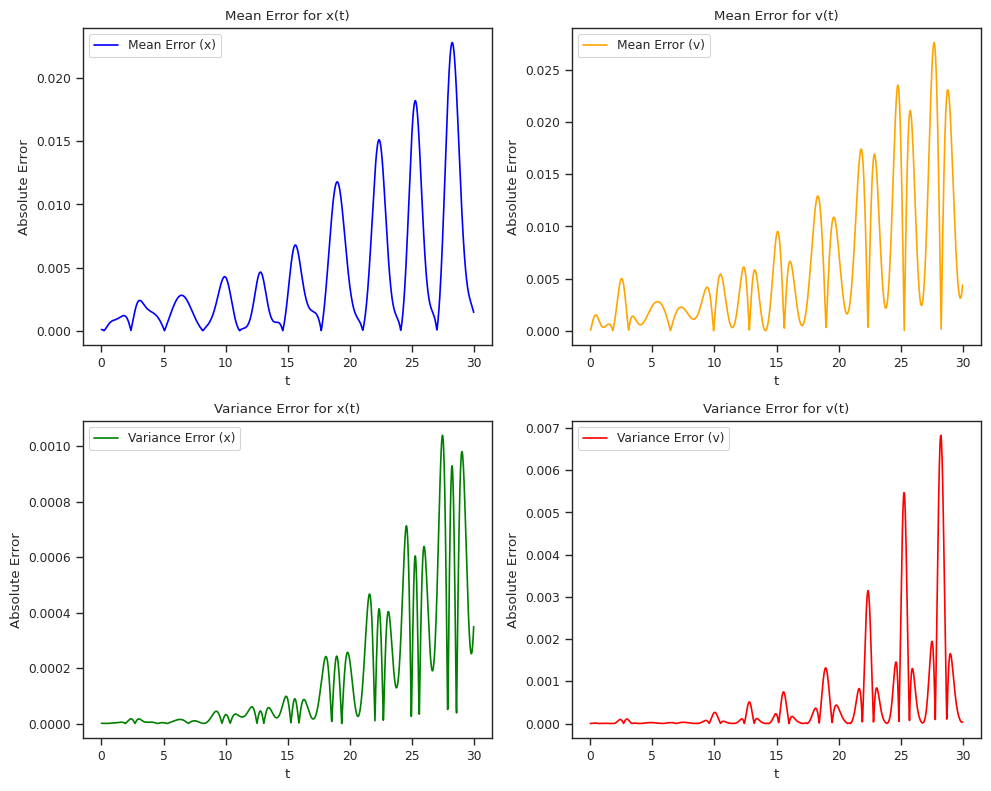

In [6]:
import numpy as np

# Select time indices up to 30
t_max = 30
idx = np.searchsorted(ts, t_max)
ts_filtered = ts[:idx]

# Compute Absolute Mean Errors
x_mean_error = np.abs(sol_mu[:idx, 0] - mean_sol_MC[:idx, 0])
v_mean_error = np.abs(sol_mu[:idx, 1] - mean_sol_MC[:idx, 1])

# Compute Absolute Variance Errors
x_variance_error = np.abs(x_var[:idx] - var_sol_MC[:idx, 0])
v_variance_error = np.abs(v_var[:idx] - var_sol_MC[:idx, 1])

# Compute RMSE for Mean
rmse_x_mean = np.sqrt(np.mean(x_mean_error**2))
rmse_v_mean = np.sqrt(np.mean(v_mean_error**2))

# Compute RMSE for Variance
rmse_x_var = np.sqrt(np.mean(x_variance_error**2))
rmse_v_var = np.sqrt(np.mean(v_variance_error**2))

# # # Print results
# print(f"RMSE of Mean for x(t): {rmse_x_mean:.5f}")
# print(f"RMSE of Mean for v(t): {rmse_v_mean:.5f}")
# print(f"RMSE of Variance for x(t): {rmse_x_var:.5f}")
# print(f"RMSE of Variance for v(t): {rmse_v_var:.5f}")

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(ts_filtered, x_mean_error, label="Mean Error (x)", color='blue')
ax[0, 0].set(xlabel="t", ylabel="Absolute Error", title="Mean Error for x(t)")
ax[0, 0].legend()
ax[0, 1].plot(ts_filtered, v_mean_error, label="Mean Error (v)", color='orange')
ax[0, 1].set(xlabel="t", ylabel="Absolute Error", title="Mean Error for v(t)")
ax[0, 1].legend()
ax[1, 0].plot(ts_filtered, x_variance_error, label="Variance Error (x)", color='green')
ax[1, 0].set(xlabel="t", ylabel="Absolute Error", title="Variance Error for x(t)")
ax[1, 0].legend()
ax[1, 1].plot(ts_filtered, v_variance_error, label="Variance Error (v)", color='red')
ax[1, 1].set(xlabel="t", ylabel="Absolute Error", title="Variance Error for v(t)")
ax[1, 1].legend()
plt.tight_layout()
plt.show()


### Part D: Local sensitivity analysis results in a Gaussian process approximation of the uncertain dynamical system

As we discussed in the [theory](https://predictivesciencelab.github.io/advanced-scientific-machine-learning/up/sensitivity_analysis/01_theory.html), local sensitivity analysis results in a (vector-valued) Gaussian process.

+ Plot the covariance of $x(t)$ with $x(0)$, i.e., plot the function:

    $$
    g(t) = \text{Cov}[x(t), x(0)] = \nabla_\theta x(t)\Sigma \nabla_\theta x(0)^\top,
    $$

    for $t$ in $[0, 5]$.
    (Recall $x$ is the *position* of the oscillator.)

+ Take five (5) samples from the Gaussian process corresponding to $x(t)$ and plot them as functions of time for $t \in [0, 5]$. Hint: The mean is just the local sensitivity analysis estimate of the mean. Then you will have to find the covariance matrix of $x(t_i)$, for $t_i$ points in $[0,5]$, and sample from the corresponding multivariate Gaussian distribution.
(And don't forget to add some jitter to the diagonal of the covariance matrix for numerical stability.)

**Answer:**

In [59]:
# Your response in code and markdown cells here


t_max = 5
idx = np.searchsorted(ts, t_max)
print(idx)
ts_filtered = ts[:idx]
print(ts_filtered.shape)


J_x = jac_sol_mu[:,:,0]

print(J_x.shape)

print(J_x[:idx].shape)
print(cov_theta.shape)

g_t = np.einsum("ik,kl,ij->ij", J_x[:idx], cov_theta, J_x[0].T)


200
(200,)
(2000, 2)
(200, 2)
(7, 7)


ValueError: einstein sum subscripts string contains too many subscripts for operand 2

### Part E: Global sensitivity analysis

Sobol sensitivity indices are a popular way to quantify the importance of the parameters of a model.
The caveat is that they assume that the inputs of the model are independent and uniformly distributed.
So, before applying the method, we will have to transform the random variables $\theta_i$ to uniform random variables $\xi_i$.

+ Find random variables $\xi_i$ and transformation functions $F_i$, such that $\xi_i \sim U(0, 1)$ and $\theta_i = F_i^{-1}(\xi_i)$. Explicitly write down what what are these transformation functions. Hint: Recall that if $X$ is a random variable with CDF $F_X$, then $Y = F_X(X)$ is a random variable with uniform distribution in $[0, 1]$.
+ Implement a solver that takes $\xi$ as an input and returns the solution of the Duffing oscillator for a given the interval of time $[0, 50]$ with a time step of 0.1.
+ Compute the first order Sobol sensitivity indices for the Duffing oscillator using the solver you just implemented. Make sure you have used enough samples to get a convergent estimate of the Sobol indices. You can use the [SALib](https://salib.readthedocs.io/en/latest/) library to do this.

**Answer:**

In [8]:
# Your response in code and markdown cells here